## Implementação de carro elétrico acionado por Motor CC com análise de freio regenerativo

### Importação das bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### EDOs das dinâmicas

In [2]:
# Dinâmica do motor e da translação

def func(x, t, L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn): 
    dx0dt = (Ea - Kv * x[1] - Ra * x[0]) / L # x[0] = ia, x[1] = w, x[2] = soc
    dx1dt = (Kv*x[0] - b*x[1] - c*x[1]**2*r - m*g*r*np.sin(alpha)) / J
    dx2dt = - x[0]/(cn*60)
    return (dx0dt, dx1dt, dx2dt)

### Parametrização

In [3]:
L = 0.02 # indutância
Kv = 1.39 # constante de velocidade
Ra = 0.1 # resistência de armadura

J = 0.05 # inércia
b = 0.1 # coeficiente de atrito viscoso

r = 20e-2 # raio da roda
c = 0.3 # coeficiente de atrito viscoso
m = 200 # massa
g = 9.8 # aceleração da gravidade
cn = 50.4 # capacidade nominal

### Simulação da dinâmica

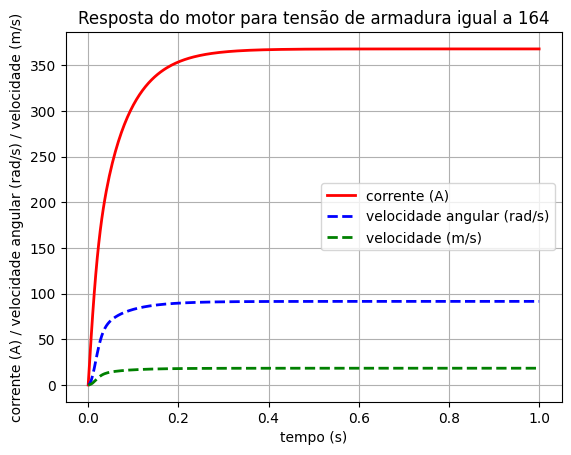

In [4]:
x0 = [0, 0, 80]
Ea = 164
alpha = 0
t = np.linspace(0, 1, 300) # vetor de tempo
result = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
plt.figure()
plt.plot(t, result[:,0] , 'r-', linewidth=2, label='corrente (A)')
plt.plot(t, result[:,1], 'b--', linewidth=2, label='velocidade angular (rad/s)')
plt.plot(t, result[:,1]*r, 'g--', linewidth=2, label='velocidade (m/s)')
plt.xlabel('tempo (s)')
plt.ylabel('corrente (A) / velocidade angular (rad/s) / velocidade (m/s)')
plt.title(f'Resposta do motor para tensão de armadura igual a {Ea}')
plt.legend()
plt.grid()
plt.show()

### Simulação da dinâmica (cálculo do SoC)

In [5]:
x0 = [0, 0, 80]
Ea = 164
alpha = 0
t = np.linspace(0, 400, 300) # vetor de tempo
result = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))

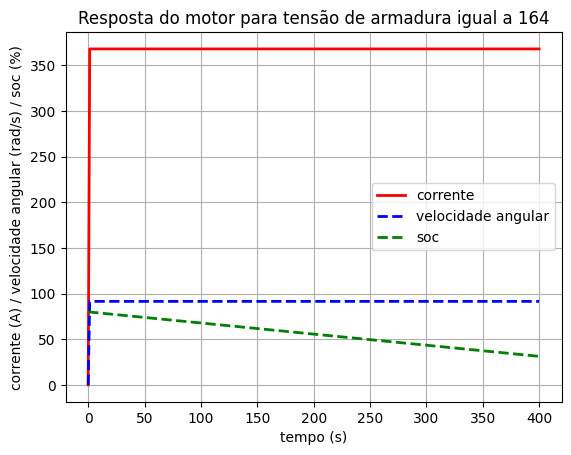

In [6]:
plt.figure()
plt.plot(t, result[:,0] , 'r-', linewidth=2, label='corrente')
plt.plot(t, result[:,1], 'b--', linewidth=2, label='velocidade angular')
plt.plot(t, result[:,2], 'g--', linewidth=2, label='soc')
plt.xlabel('tempo (s)')
plt.ylabel('corrente (A) / velocidade angular (rad/s) / soc (%)')
plt.title(f'Resposta do motor para tensão de armadura igual a {Ea}')
plt.legend()
plt.grid()
plt.show()

## Implementando a malha de controle

### Referência fixa

In [7]:
Kp = 0.5
Ki = 0.5

V_ref = 10
Ea = 0
alpha = 0

t = np.linspace(0, 1, 100)
x0 = [0, 0, 80]
din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
ia = din[-1][0]
w = din[-1][1]
v = w*r
soc = din[-1][2]
erro = V_ref - v
v_history = [v]
Ea_history = [Ea]
Ref_history = [V_ref]
error_history = [erro]
ia_history = [ia]
soc_history = [soc]

In [8]:
for i in range(150):
    Ea = Kp*erro + Ki*sum(error_history)
    if Ea > 164: # controle de saturação
        Ea = 164
    x0 = [ia, w, soc]
    din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
    ia = din[-1][0]
    w = din[-1][1]
    v = w*r
    soc = din[-1][2]
    erro = (V_ref - v)
    v_history.append(v)
    Ea_history.append(Ea)
    Ref_history.append(V_ref)
    error_history.append(erro)
    ia_history.append(ia)
    soc_history.append(soc)

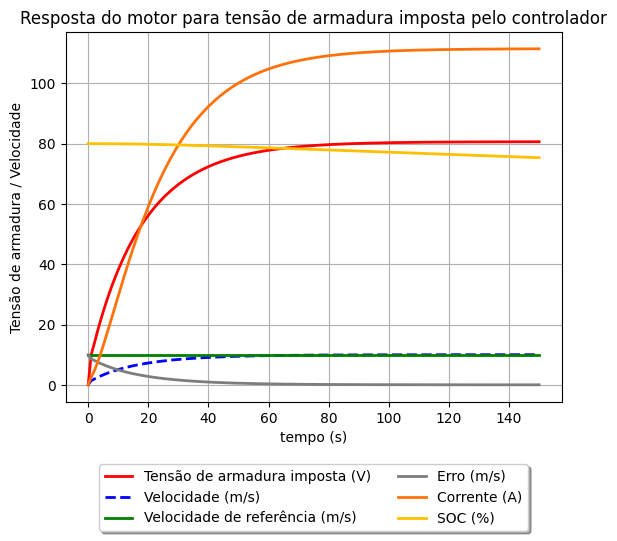

In [9]:
def grafico():
    plt.figure()
    plt.plot(Ea_history, 'r-', linewidth=2, label='Tensão de armadura imposta (V)')
    plt.plot(v_history, 'b--', linewidth=2, label='Velocidade (m/s)')
    plt.plot(Ref_history, 'g-', linewidth=2, label='Velocidade de referência (m/s)')
    plt.plot(error_history, '#7D7D7D', linewidth=2, label='Erro (m/s)')
    plt.plot(ia_history, '#FF720A', linewidth=2, label='Corrente (A)')
    plt.plot(soc_history, '#FFC000', linewidth=2, label='SOC (%)')
    plt.xlabel('tempo (s)')
    plt.ylabel('Tensão de armadura / Velocidade')
    plt.title('Resposta do motor para tensão de armadura imposta pelo controlador')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    plt.grid()
    plt.show()
grafico()

### Alternando a referência

In [10]:
Kp = 0.5
Ki = 0.5

V_ref = 10
Ea = 0
alpha = 0

t = np.linspace(0, 1, 100)
x0 = [0, 0, 80]
din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
ia = din[-1][0]
w = din[-1][1]
v = w*r
soc = din[-1][2]
erro = V_ref - v
v_history = [v]
Ea_history = [Ea]
Ref_history = [V_ref]
error_history = [erro]
ia_history = [ia]
soc_history = [soc]

In [11]:
for i in range(150):
    if i == 75:
        V_ref = 5
    Ea = Kp*erro + Ki*sum(error_history)
    if Ea > 164: # controle de saturação
        Ea = 164
    x0 = [ia, w, soc]
    din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
    ia = din[-1][0]
    w = din[-1][1]
    v = w*r
    soc = din[-1][2]
    erro = (V_ref - v)
    v_history.append(v)
    Ea_history.append(Ea)
    Ref_history.append(V_ref)
    error_history.append(erro)
    ia_history.append(ia)
    soc_history.append(soc)

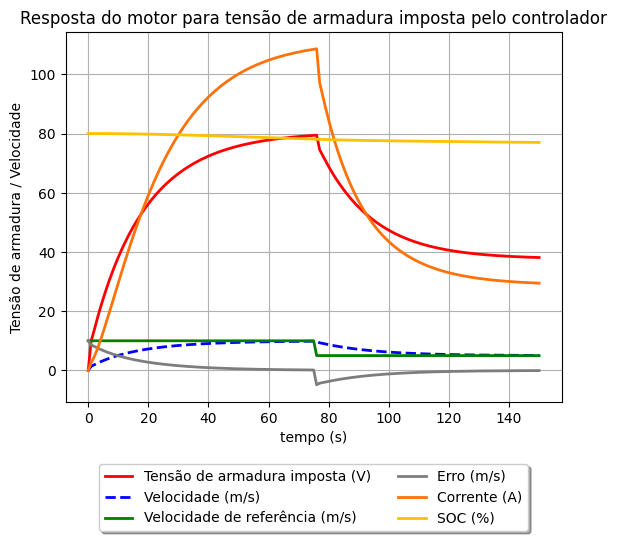

In [12]:
grafico()

### Alternando a referência e controle do SoC

In [13]:
Kp = 0.5
Ki = 0.5

V_ref = 10
Ea = 0
alpha = 0

t = np.linspace(0, 1, 100)
x0 = [0, 0, 80]
din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
ia = din[-1][0]
w = din[-1][1]
v = w*r
soc = din[-1][2]
erro = V_ref - v
v_history = [v]
Ea_history = [Ea]
Ref_history = [V_ref]
error_history = [erro]
ia_history = [ia]
soc_history = [soc]

In [14]:
aumentar = False
i = 0
while True:
    if i%200 == 0 and aumentar:
        V_ref += 5
        aumentar = False
    elif i%200 == 0 and not aumentar:
        V_ref -= 5
        aumentar = True
    Ea = Kp*erro + Ki*sum(error_history)
    if Ea > 164: # controle de saturação
        Ea = 164
    x0 = [ia, w, soc]
    din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
    ia = din[-1][0]
    w = din[-1][1]
    v = w*r
    soc = din[-1][2]
    erro = (V_ref - v)
    v_history.append(v)
    Ea_history.append(Ea)
    Ref_history.append(V_ref)
    error_history.append(erro)
    ia_history.append(ia)
    soc_history.append(soc)
    if soc < 20:
        break
    i += 1

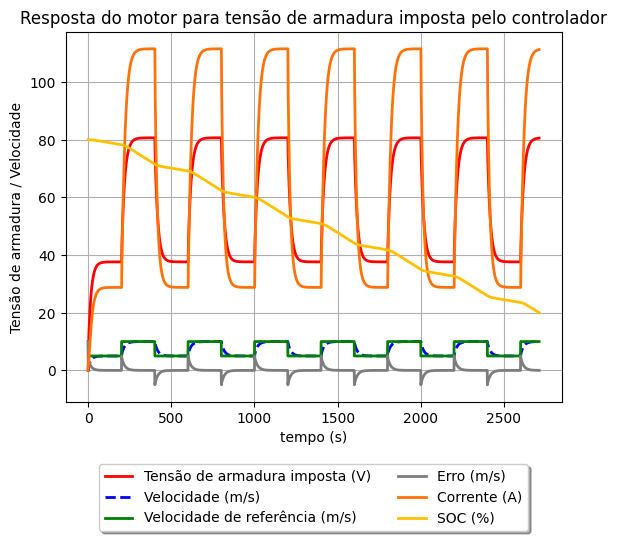

In [15]:
grafico()

### Inserindo uma perturbação

In [16]:
Kp = 0.5
Ki = 0.5

V_ref = 10
Ea = 0
alpha = 0

t = np.linspace(0, 1, 100)
x0 = [0, 0, 80]
din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
ia = din[-1][0]
w = din[-1][1]
v = w*r
soc = din[-1][2]
erro = V_ref - v
v_history = [v]
Ea_history = [Ea]
Ref_history = [V_ref]
error_history = [erro]
ia_history = [ia]
soc_history = [soc]

In [17]:
for i in range(200):
    if i == 100:
        alpha = np.pi/12 # 15 graus
    Ea = Kp*erro + Ki*sum(error_history)
    if Ea > 164: # controle de saturação
        Ea = 164
    x0 = [ia, w, soc]
    din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
    ia = din[-1][0]
    w = din[-1][1]
    v = w*r
    soc = din[-1][2]
    erro = (V_ref - v)
    v_history.append(v)
    Ea_history.append(Ea)
    Ref_history.append(V_ref)
    error_history.append(erro)
    ia_history.append(ia)
    soc_history.append(soc)

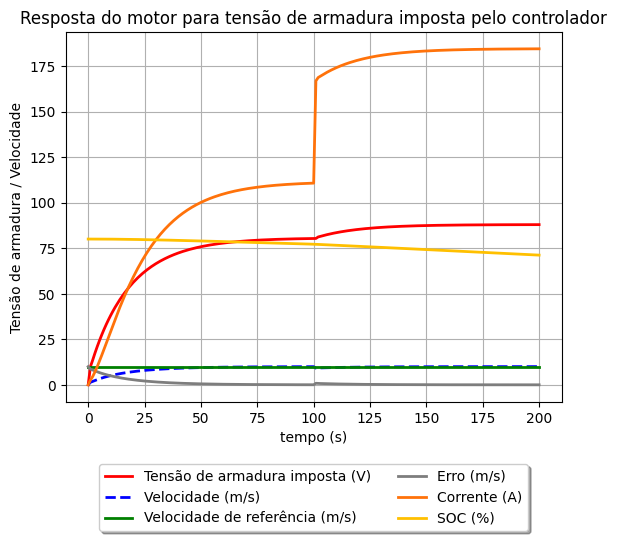

In [18]:
grafico()

### Desaceleração, perturbação e SoC

In [19]:
Kp = 0.5
Ki = 0.5

V_ref = 10
Ea = 0
alpha = 0

t = np.linspace(0, 1, 100)
x0 = [0, 0, 80]
din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
ia = din[-1][0]
w = din[-1][1]
v = w*r
soc = din[-1][2]
erro = V_ref - v
v_history = [v]
Ea_history = [Ea]
Ref_history = [V_ref]
error_history = [erro]
ia_history = [ia]
soc_history = [soc]

In [20]:
aumentar = False
i = 0
while True:
    if i%200 == 0 and aumentar:
        V_ref += 5
        aumentar = False
    elif i%200 == 0 and not aumentar:
        V_ref -= 5
        aumentar = True
    if i == 900:
        alpha = np.pi/12
    Ea = Kp*erro + Ki*sum(error_history)
    if Ea > 164: # controle de saturação
        Ea = 164
    x0 = [ia, w, soc]
    din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
    ia = din[-1][0]
    w = din[-1][1]
    v = w*r
    soc = din[-1][2]
    erro = (V_ref - v)
    v_history.append(v)
    Ea_history.append(Ea)
    Ref_history.append(V_ref)
    error_history.append(erro)
    ia_history.append(ia)
    soc_history.append(soc)
    if soc < 20:
        break
    i += 1

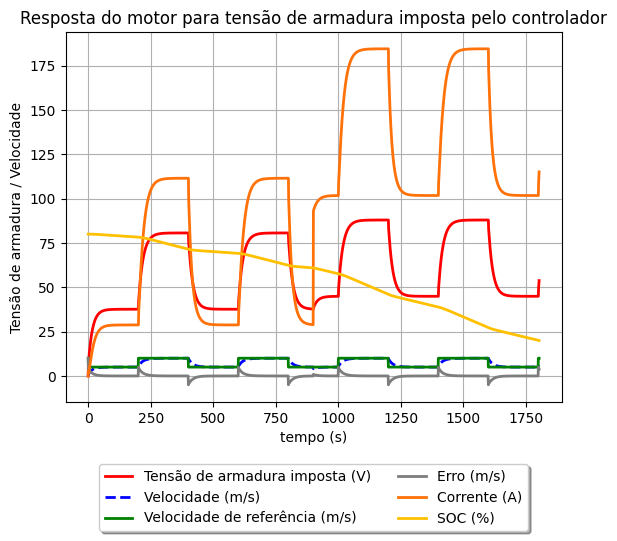

In [21]:
grafico()

### Limite de tensão com base no SoC

In [56]:
Kp = 0.5
Ki = 0.5

V_ref = 10
Ea = 0
alpha = 0
tensao_max = 164

t = np.linspace(0, 1, 100)
x0 = [0, 0, 80]
din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
ia = din[-1][0]
w = din[-1][1]
v = w*r
soc = din[-1][2]
erro = V_ref - v
tensao_saida = tensao_max*soc/100
v_history = [v]
Ea_history = [Ea]
Ref_history = [V_ref]
error_history = [erro]
ia_history = [ia]
soc_history = [soc]
tensao_saida_history = [tensao_saida]

In [57]:
aumentar = False
i = 0
while True:
    if i%200 == 0 and aumentar:
        V_ref += 5
        aumentar = False
    elif i%200 == 0 and not aumentar:
        V_ref -= 5
        aumentar = True
    # if i == 2500:
    #     alpha = np.pi/12
    Ea = Kp*erro + Ki*sum(error_history)
    if Ea > tensao_saida: # controle de saturação
        Ea = tensao_saida
    x0 = [ia, w, soc]
    din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
    ia = din[-1][0]
    w = din[-1][1]
    v = w*r
    soc = din[-1][2]
    erro = (V_ref - v)
    tensao_saida = tensao_max*soc/100
    v_history.append(v)
    Ea_history.append(Ea)
    Ref_history.append(V_ref)
    error_history.append(erro)
    ia_history.append(ia)
    soc_history.append(soc)
    tensao_saida_history.append(tensao_saida)
    if soc < 20:
        break
    i += 1

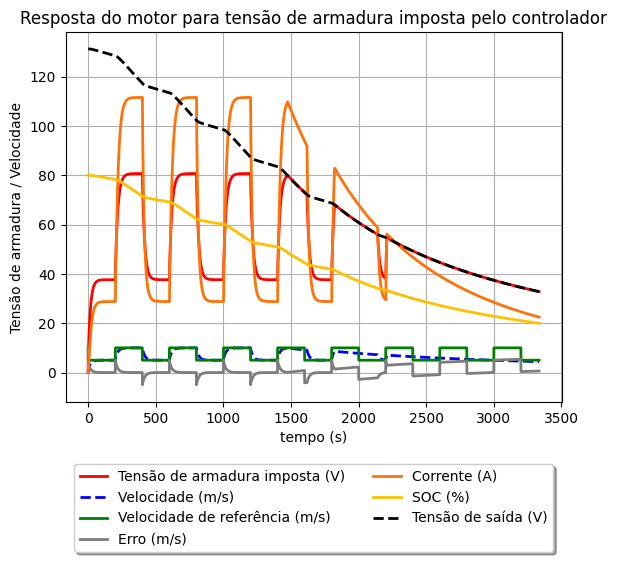

In [58]:
plt.figure()
plt.plot(Ea_history, 'r-', linewidth=2, label='Tensão de armadura imposta (V)')
plt.plot(v_history, 'b--', linewidth=2, label='Velocidade (m/s)')
plt.plot(Ref_history, 'g-', linewidth=2, label='Velocidade de referência (m/s)')
plt.plot(error_history, '#7D7D7D', linewidth=2, label='Erro (m/s)')
plt.plot(ia_history, '#FF720A', linewidth=2, label='Corrente (A)')
plt.plot(soc_history, '#FFC000', linewidth=2, label='SOC (%)')
plt.plot(tensao_saida_history, 'k--', linewidth=2, label='Tensão de saída (V)')
plt.xlabel('tempo (s)')
plt.ylabel('Tensão de armadura / Velocidade')
plt.title('Resposta do motor para tensão de armadura imposta pelo controlador')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.grid()
plt.show()

### Parque de diversões

http://repositorio.utfpr.edu.br/jspui/bitstream/1/29110/9/simulacaofreiosregenerativos.pdf

Página 26: considerando tempo de frenagem = 1s, Pd = Ed

In [110]:
Kp = 0.5
Ki = 0.5

V_ref = 10
Ea = 0
alpha = 0
tensao_max = 164

t = np.linspace(0, 1, 100)
x0 = [0, 0, 80]
din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
ia = din[-1][0]
w = din[-1][1]
v = w*r
soc = din[-1][2]
erro = V_ref - v
tensao_saida = tensao_max*soc/100
v0 = din[0][1]*r
Pd = m*(v0**2 - v**2)/(2)
v_history = [v]
Ea_history = [Ea]
Ref_history = [V_ref]
error_history = [erro]
ia_history = [ia]
soc_history = [soc]
tensao_saida_history = [tensao_saida]
Pd_history = [Pd]

In [111]:
aumentar = False
i = 0
while True:
    if i%200 == 0 and aumentar:
        V_ref += 5
        aumentar = False
    elif i%200 == 0 and not aumentar:
        V_ref -= 5
        aumentar = True
    # if i == 2500:
    #     alpha = np.pi/12
    Ea = Kp*erro + Ki*sum(error_history)
    if Ea > tensao_saida*0.8: # controle de saturação
        Ea = tensao_saida*0.8
    x0 = [ia, w, soc]
    din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha, cn))
    ia = din[-1][0]
    w = din[-1][1]
    v = w*r
    soc = din[-1][2]
    erro = (V_ref - v)
    tensao_saida = (tensao_max)*soc/100
    v0 = din[0][1]*r
    if v0 > v:
        Pd = m*(v0**2 - v**2)/(2)
    else:
        Pd = 0
    v_history.append(v)
    Ea_history.append(Ea)
    Ref_history.append(V_ref)
    error_history.append(erro)
    ia_history.append(ia)
    soc_history.append(soc)
    tensao_saida_history.append(tensao_saida)
    Pd_history.append(Pd)
    if soc < 20:
        break
    i += 1

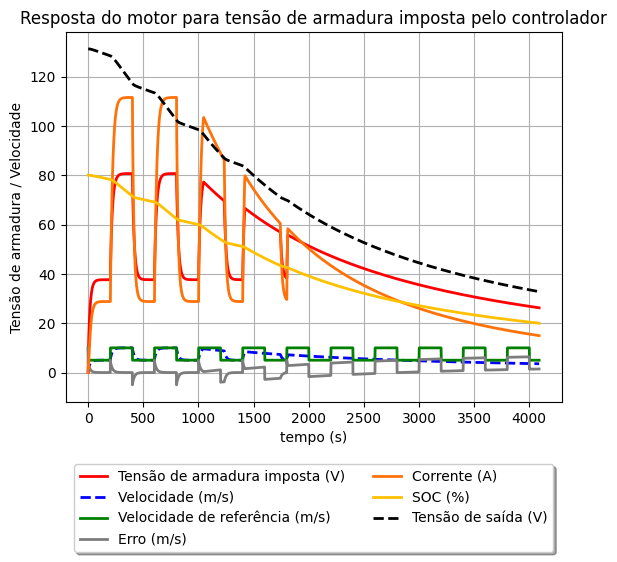

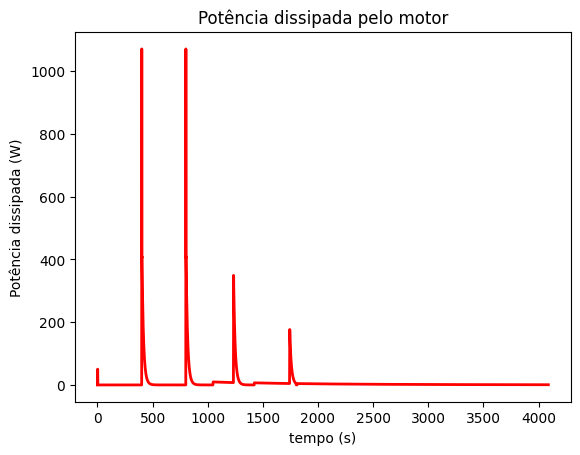

In [112]:
plt.figure(1)
plt.plot(Ea_history, 'r-', linewidth=2, label='Tensão de armadura imposta (V)')
plt.plot(v_history, 'b--', linewidth=2, label='Velocidade (m/s)')
plt.plot(Ref_history, 'g-', linewidth=2, label='Velocidade de referência (m/s)')
plt.plot(error_history, '#7D7D7D', linewidth=2, label='Erro (m/s)')
plt.plot(ia_history, '#FF720A', linewidth=2, label='Corrente (A)')
plt.plot(soc_history, '#FFC000', linewidth=2, label='SOC (%)')
plt.plot(tensao_saida_history, 'k--', linewidth=2, label='Tensão de saída (V)')
plt.xlabel('tempo (s)')
plt.ylabel('Tensão de armadura / Velocidade')
plt.title('Resposta do motor para tensão de armadura imposta pelo controlador')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.grid()
plt.figure(2)
plt.plot(Pd_history, 'r-', linewidth=2, label='Potência dissipada (W)')
plt.xlabel('tempo (s)')
plt.ylabel('Potência dissipada (W)')
plt.title('Potência dissipada pelo motor')
plt.show()